In [5]:
"""Solve
u_t + (u^2 / 2)_x = 0 on [-1, 6]
with fixed boundary conditions.
"""

'Solve\nu_t + (u^2 / 2)_x = 0 on [-1, 6]\nwith fixed boundary conditions.\n'

In [6]:
import numpy as np
import matplotlib.pyplot as plt


In [7]:
# Initial Conditions
def step(x):
    u = np.zeros(x.shape)
    for j in range(len(x)):
        if x[j] < 0:
            u[j] = 2.0
        elif (x[j] >= 0) and (x[j] <= 1):
            u[j] = 2.0 - x[j]
        else:
            u[j] = 1.0
    return u

# Exact rarefaction to compare
def exact_rarefaction(x, t):
    u = np.zeros_like(x)
    if t < 1:
        u[x < 2*t] = 2.0
        mask_linear = (x >= 2*t) & (x <= 1+t)
        u[mask_linear] = (2 - x[mask_linear])/(1-t)
        u[x > 1+t] = 1.0
    else:
        x_s = 2 + 1.5*(t-1)
        u[x < x_s] = 2.0
        u[x >= x_s] = 1.0
    return u

end_time = 2.0
gamma = 0.95
nx = 128

In [8]:
x, hx = np.linspace(-1, 6, nx, endpoint=False, retstep=True)
# Ghost cell mask: pretend first and last DoF are ghost cells
mask = np.ones(len(x), dtype=bool)
mask[:1] = mask[-1:] = False
# Indexing arrays
K = np.arange(0, nx)    # 0, ..., nx-1
Km1 = np.roll(K, 1)     # nx-1, 0, 1, ..., nx-2
Kp1 = np.roll(K, -1)    # 1, ..., nx

ht = hx * gamma
nt = int(np.ceil(end_time / ht))
ht = end_time / nt

print('T = %g' % end_time)
print('tsteps = %d' % nt)
print('    hx = %g' % hx)
print('    ht = %g' % ht)
print('lambda = %g' % gamma)

u = step(x)
u0 = u.copy()

def f(u):
    return u**2/2

def fprime(u):
    return u

T = 2
tsteps = 39
    hx = 0.0546875
    ht = 0.0512821
lambda = 0.95


/tmp/ipykernel_72098/1972349493.py:24: RuntimeWarning: overflow encountered in scalar power
  return u**2/2
/tmp/ipykernel_72098/3680135169.py:15: RuntimeWarning: overflow encountered in scalar multiply
  return 0.5*(f(uL) + f(uR)) - 0.5*alpha*(uR - uL)
/tmp/ipykernel_72098/3680135169.py:15: RuntimeWarning: invalid value encountered in scalar subtract
  return 0.5*(f(uL) + f(uR)) - 0.5*alpha*(uR - uL)
/tmp/ipykernel_72098/3680135169.py:48: RuntimeWarning: invalid value encountered in scalar subtract
  unew[j] = u[j] - (ht/hx)*(F[j+1] - F[j])


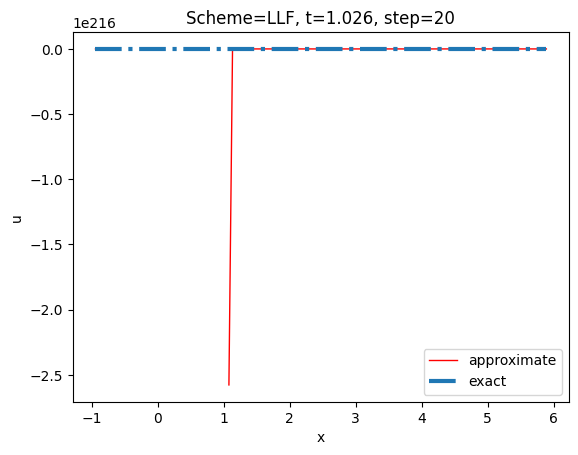

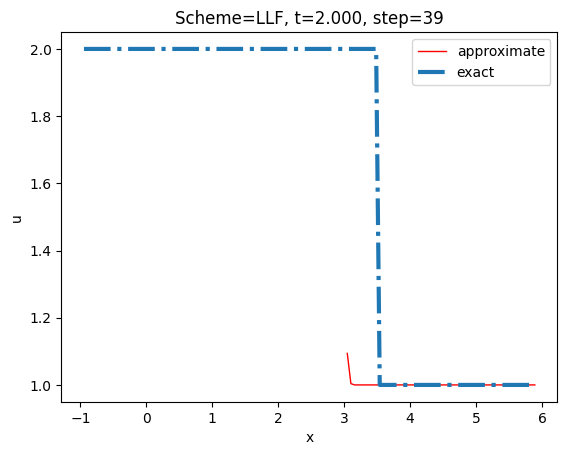

In [9]:
# ==========================
# 4) HELPER FUNCTIONS
# ==========================

def minmod(a, b):
    """Classic minmod limiter function."""
    if a * b <= 0:
        return 0.0
    else:
        return np.sign(a) * min(abs(a), abs(b))

def flux_LLF(uL, uR):
    """Local Lax-Friedrichs flux for Burgers."""
    alpha = max(abs(uL), abs(uR))  # f'(u)=u => wave speed = |u|
    return 0.5*(f(uL) + f(uR)) - 0.5*alpha*(uR - uL)

def flux_Godunov(uL, uR):
    """Godunov flux for scalar Burgers equation."""
    if uL <= uR:
        # Rarefaction
        if 0 >= uR:
            return f(uR)
        elif 0 <= uL:
            return f(uL)
        else:
            # 0 is in [uL, uR] => flux=0 for Burgers
            return 0.0
    else:
        # Shock
        s = 0.5*(uL + uR)  # shock speed
        if s > 0:
            return f(uL)
        else:
            return f(uR)

def update_LLF(u, hx, ht):
    """First-order update using Local Lax-Friedrichs flux."""
    unew = u.copy()

    # Compute fluxes at interfaces
    F = np.zeros(nx+1)
    for j in range(nx):
        if j+1 < nx:
            F[j+1] = flux_LLF(u[j], u[j+1])

    # Update interior cells
    for j in range(1, nx-1):
        unew[j] = u[j] - (ht/hx)*(F[j+1] - F[j])

    # Enforce boundary conditions (ghost cells fixed)
    unew[0]  = 2.0
    unew[-1] = 1.0
    return unew

def update_Godunov(u, hx, ht):
    """First-order update using Godunov flux."""
    unew = u.copy()

    # Compute fluxes at interfaces
    F = np.zeros(nx+1)
    for j in range(nx):
        if j+1 < nx:
            F[j+1] = flux_Godunov(u[j], u[j+1])

    # Update interior
    for j in range(1, nx-1):
        unew[j] = u[j] - (ht/hx)*(F[j+1] - F[j])

    # Enforce boundary conditions
    unew[0]  = 2.0
    unew[-1] = 1.0
    return unew

def spatial_reconstruct_minmod(u, hx):
    """
    Compute minmod-limited slopes for each cell,
    return arrays of left- and right-interface values.
    """
    slope = np.zeros(nx)
    for j in range(1, nx-1):
        slope_left  = (u[j] - u[j-1]) / hx
        slope_right = (u[j+1] - u[j]) / hx
        slope[j] = minmod(slope_left, slope_right)

    # For each cell j, define:
    #   u^R_j = u[j] + (hx/2)*slope[j]   (right edge of cell j)
    #   u^L_j = u[j] - (hx/2)*slope[j]   (left edge of cell j)
    # But we mainly need interface values between j and j+1:
    #   interface j+1/2 has left value u^R_j, right value u^L_{j+1}.
    uL = np.zeros(nx)  # left interface value
    uR = np.zeros(nx)  # right interface value

    for j in range(nx):
        # By default, keep them the same as cell average
        uL[j] = u[j]
        uR[j] = u[j]

    # Interior
    for j in range(1, nx-1):
        uR[j] = u[j] + 0.5*hx*slope[j]
        uL[j] = u[j] - 0.5*hx*slope[j]

    return uL, uR

def L_operator_LLF(u, hx):
    """
    Compute the spatial derivative operator L(u) for Burgers,
    using LLF flux on the piecewise linear reconstructions.
    L(u) is the right-hand side of du/dt = L(u).
    We'll do a standard finite-volume difference:
       u_j^{n+1} = u_j^n - (dt/hx)* [F_{j+1/2} - F_{j-1/2}].
    So L(u)_j = -(1/hx)* [F_{j+1/2} - F_{j-1/2}].
    """
    # Enforce ghost cell values for consistency before flux calc
    u[0]  = 2.0
    u[-1] = 1.0

    # Reconstruct
    uL, uR = spatial_reconstruct_minmod(u, hx)

    # Compute fluxes
    nx_local = len(u)
    F = np.zeros(nx_local+1)
    for j in range(nx_local):
        if j+1 < nx_local:
            # interface j+1/2 => left state = uR[j], right state = uL[j+1]
            F[j+1] = flux_LLF(uR[j], uL[j+1])

    # Build L(u)
    Lu = np.zeros_like(u)
    for j in range(1, nx_local-1):
        Lu[j] = -(1.0/hx)*(F[j+1] - F[j])

    # Zero out the boundary's L(u) to keep them fixed
    Lu[0]  = 0.0
    Lu[-1] = 0.0
    return Lu

def update_RK2(u, hx, ht):
    """
    Second-order TVD Runge-Kutta (Heun or midpoint) method
    with minmod-limited reconstruction and LLF flux.
    """
    # Stage 1
    k1 = L_operator_LLF(u.copy(), hx)
    u_star = u + ht*k1

    # Stage 2
    k2 = L_operator_LLF(u_star.copy(), hx)
    unew = u + ht*k2

    # Final boundary enforcement
    unew[0]  = 2.0
    unew[-1] = 1.0
    return unew

# ==========================
# 5) CHOOSE A SCHEME
# ==========================
scheme = "LLF"       # or "Godunov" or "RK2"

# ==========================
# 6) MAIN TIME LOOP
# ==========================
for n in range(1, nt+1):
    time = n * ht

    # ---------------------------
    # Update "u" using chosen scheme
    # ---------------------------
    if scheme == "LLF":
        u = update_LLF(u, hx, ht)
    elif scheme == "Godunov":
        u = update_Godunov(u, hx, ht)
    elif scheme == "RK2":
        u = update_RK2(u, hx, ht)
    else:
        raise ValueError("Unknown scheme '%s'." % scheme)

    # ---------------------------
    # Compare with exact solution at t=1 or t=2
    # ---------------------------
    uexact = exact_rarefaction(x, time)

    # Plot if we are near t=1 or t=2
    if abs(time - 1.) < ht/2 or abs(time - 2.) < ht/2:
        plt.figure()
        plt.title(f'Scheme={scheme}, t={time:.3f}, step={n}')
        plt.plot(x[mask], u[mask], 'r-', linewidth=1, label='approximate')
        plt.plot(x[mask], uexact[mask], '-.', linewidth=3, label='exact')
        plt.xlabel('x')
        plt.ylabel('u')
        plt.legend()
        plt.show()

T = 2
tsteps = 39
    hx = 0.0546875
    ht = 0.0512821
lambda = 0.95


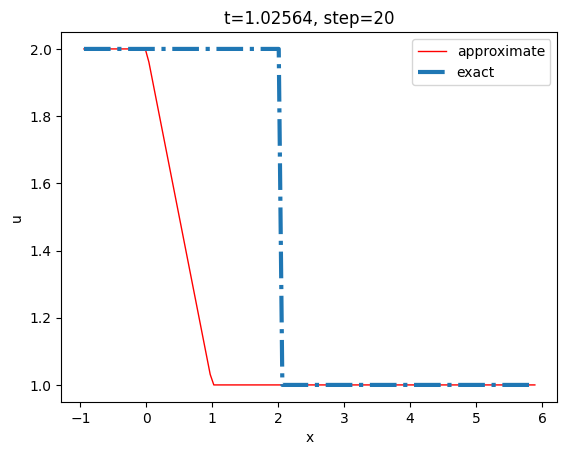

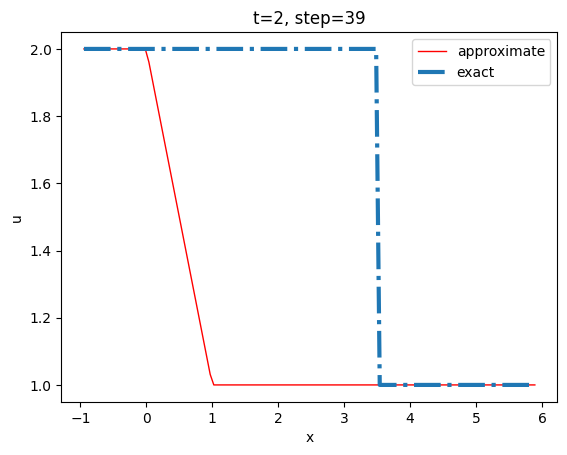

In [4]:

for n in range(1, nt+1):
    # (Here you would implement the update for u using LLF, Godunov, or RK2 schemes.)
    # For demonstration purposes, we leave u unchanged.

    # Compute the exact solution at the current time
    time = n * ht
    uexact = exact_rarefaction(x, time)

    # Plot the computed (approximate) and exact solution at t = 1 and t = 2.
    if abs(time - 1.) < ht/2 or abs(time - 2.) < ht/2:
        plt.figure()
        plt.title('t=%g, step=%d' % (time, n))
        plt.plot(x[mask], u[mask], 'r-', linewidth=1, label='approximate')
        plt.plot(x[mask], uexact[mask], '-.', linewidth=3, label='exact')
        plt.xlabel('x')
        plt.ylabel('u')
        plt.legend()
        plt.show()


